# Lokaverkefni TÖL403G 2025

## Höfundar
Sigurður Ari Stefánsson

Svava Þóra Árnadóttir

## imports

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Liður 2.3.1 (*) 

### Þáttun

Lesið inn netið úr skránum sem eru gefnar, nodes.tsv og edges.tsv. Í skránni nodes.tsv
eru hnútar með auðkenni (id), hnit (x, y) og hvort þeir séu á aðalvegi (primary). Í skránni
edges.tsv eru leggi frá hnúti u til hnúts v með lengd length, mæld í metrum, og nafn
(name).

In [2]:
# === 1. Lesa og hreinsa gögn ===
nodes_df = pd.read_csv('nodes.tsv', sep='\t', header=None, names=['id', 'x', 'y', 'primary'])
edges_df = pd.read_csv('edges.tsv', sep='\t', header=None, names=['u', 'v', 'length', 'name'])

nodes_df = nodes_df[nodes_df['id'] != 'osmid']
edges_df = edges_df[edges_df['u'] != 'u']

nodes_df['id'] = nodes_df['id'].astype(int)
nodes_df['x'] = nodes_df['x'].astype(float)
nodes_df['y'] = nodes_df['y'].astype(float)
nodes_df['primary'] = nodes_df['primary'].astype(bool)

edges_df['u'] = edges_df['u'].astype(int)
edges_df['v'] = edges_df['v'].astype(int)
edges_df['length'] = edges_df['length'].astype(float)

# Liður 2.3.2 (**)

### Leit

Ef við setjum hleðslustöðvar á hnúta v1, . . . , vk þá er hægt að nota reikniritið dijkstra til að
finna stystu fjarlægð frá hnverjum hnúti u í hleðslustöð vi. Útfærið reikniritið sem tekur
inn lista af lokahnútum og reiknar fjarlægðir frá öllum hnútum í netinu. Athugið að netið
er stefnt net.

In [3]:
import pandas as pd
import numpy as np
import heapq
from collections import defaultdict

# 2. Búa til stefnt net: u -> listi af (v, length)
graph = defaultdict(list)
for _, row in edges_df.iterrows():
    graph[row['u']].append((row['v'], row['length']))

# 3. Finna hvaða hnútar eru hleðslustöðvar (primary == True)
charging_stations = nodes_df[nodes_df['primary'] == True]['id'].tolist()

# 4. Multi-source Dijkstra: reiknar stystu leið í einhverja hleðslustöð
def dijkstra_to_charging(graph, charging_nodes):
    dist = {node_id: float('inf') for node_id in nodes_df['id']}
    visited = set()
    heap = []

    for station in charging_nodes:
        dist[station] = 0
        heapq.heappush(heap, (0, station))

    while heap:
        current_dist, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)

        for v, weight in graph[u]:
            if dist[v] > current_dist + weight:
                dist[v] = current_dist + weight
                heapq.heappush(heap, (dist[v], v))

    return dist

# 5. Reikna stystu vegalengdir að næstu hleðslustöð
shortest_to_station = dijkstra_to_charging(graph, charging_stations)

# 6. Setja niðurstöðurnar í DataFrame
distances_df = pd.DataFrame([
    {'id': node_id, 'distance_to_station': shortest_to_station[node_id]}
    for node_id in nodes_df['id']
])

# 7. Birta fyrstu línur
print(distances_df)

# Hægt að vista niðurstöður ef vill
# distances_df.to_csv('fjarlægðir_í_hleðslustöð.csv', index=False)


                id  distance_to_station
0         12885866                    0
1         12885876                    0
2         12885922                    0
3         12885923                    0
4         12885924                    0
...            ...                  ...
10978  12601774001                    0
10979  12601774002                    0
10980  12670044370                    0
10981  12684791058                    0
10982  12684791074                    0

[10983 rows x 2 columns]


# Liður 2.3.3 (*)

### Framsetning

Setjið fimm hleðslustöðvar í netið og sýnið stystu leið fyrir fimm punkta og teiknið upp á
kort. Tékkið ykkur af með því að bera saman leiðina sem er fundin og fjarlægðina miðað
við kortavefi eins og t.d. Google Maps.

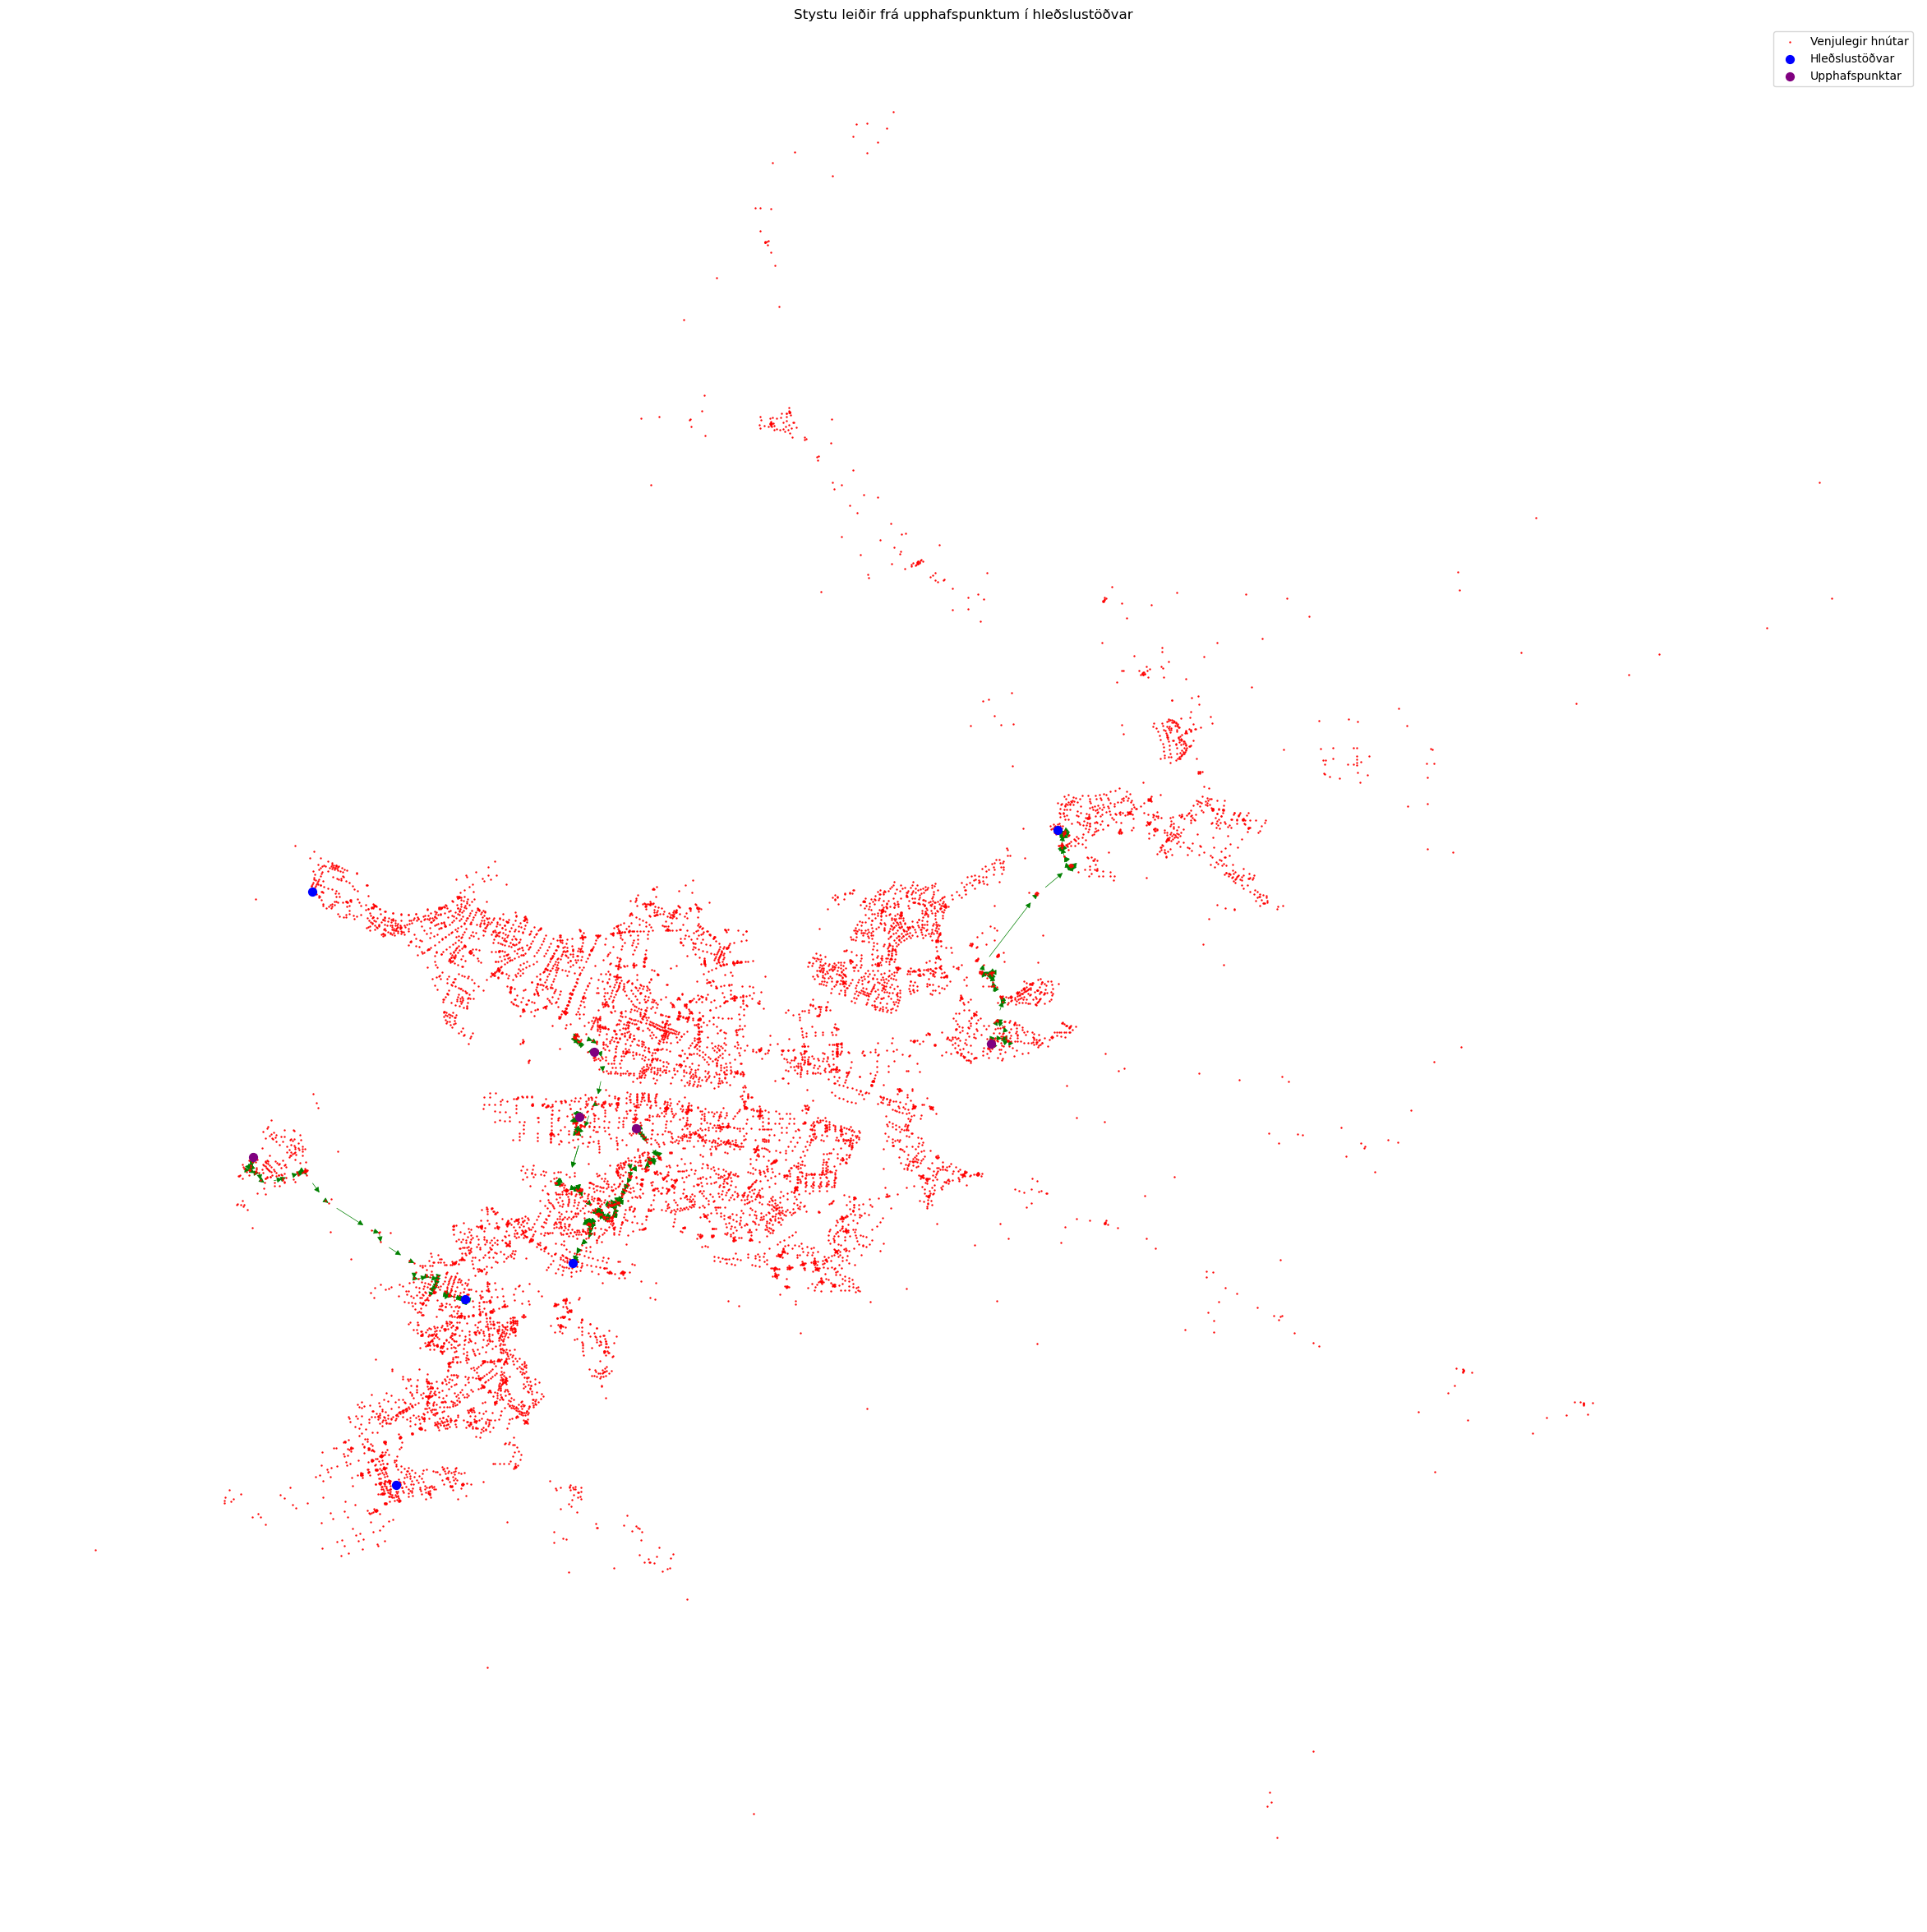

In [6]:
import pandas as pd
import numpy as np
import heapq
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict

random.seed(42)

charging_stations = random.sample(nodes_df['id'].tolist(), 5)

# === 3. Byggja stefnt net ===
graph = defaultdict(list)
for _, row in edges_df.iterrows():
    graph[row['u']].append((row['v'], row['length']))

# === 5. Velja 5 upphafshnúta sem EKKI eru hleðslustöðvar ===
non_stations = nodes_df[~nodes_df['id'].isin(charging_stations)]
start_nodes = random.sample(non_stations['id'].tolist(), 5)

# === 6. Leitarfall: Dijkstra leið frá einum hnút í næstu stöð ===
def dijkstra_path(graph, source, targets):
    dist = {node: float('inf') for node in nodes_df['id']}
    prev = {}
    heap = [(0, source)]
    dist[source] = 0
    while heap:
        d, u = heapq.heappop(heap)
        if u in targets:
            break
        for v, w in graph[u]:
            if dist[v] > d + w:
                dist[v] = d + w
                prev[v] = u
                heapq.heappush(heap, (dist[v], v))
    found = min([(t, dist[t]) for t in targets if dist[t] < float('inf')], key=lambda x: x[1], default=(None, None))
    if found[0] is None:
        return []
    path = []
    current = found[0]
    while current != source:
        path.append(current)
        current = prev[current]
    path.append(source)
    return list(reversed(path))

# === 7. Teikna netið ===
G = nx.DiGraph()
positions = {}
for _, row in nodes_df.iterrows():
    node_id = row['id']
    positions[node_id] = (row['x'], row['y'])
    G.add_node(node_id)
for _, row in edges_df.iterrows():
    G.add_edge(row['u'], row['v'], length=row['length'])

plt.figure(figsize=(30, 30))

# 1. Venjulegir hnútar
non_charging_nodes = [n for n in G.nodes if n not in charging_stations]
nx.draw_networkx_nodes(G, positions, nodelist=non_charging_nodes, node_color='red', node_size=0.5, label='Venjulegir hnútar')

# 2. Hleðslustöðvar
nx.draw_networkx_nodes(G, positions, nodelist=charging_stations, node_color='blue', node_size=50, label='Hleðslustöðvar')

# 3. Upphafshnútar
nx.draw_networkx_nodes(G, positions, nodelist=start_nodes, node_color='purple', node_size=50, label='Upphafspunktar')

# 4. Leggir
#nx.draw_networkx_edges(G, positions, alpha=0.3, arrows=True, arrowstyle='-|>', arrowsize=8, width=0.3)

# 5. Teikna stystu leiðir
for start in start_nodes:
    path = dijkstra_path(graph, start, charging_stations)
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, positions, edgelist=path_edges, edge_color='green', width=0.5)

plt.legend()
plt.title("Stystu leiðir frá upphafspunktum í hleðslustöðvar")
plt.axis('off')
plt.show()


# Liður 2.3.4 (*)

### Tímamælingar

Mælið tímann sem reikniritið dijkstra tekur að reikna allar fjarlægðir í netinu með fimm
hleðslustöðvum.

# Liður 2.3.5 (**)

### A* reikniritið

Útfærið A⋆ reikniritið sem tekur inn lista af lokahnútum og reiknar fjarlægðir frá öll-
um hnútum í netinu. Sem neðra mat á fjarlægð á milli hnútanna má taka $d(u, v) = \sqrt{(x_u − x_v )^2 + (y_u − y_v )^2}$, þ.e. beina loftlínu milli punktanna. Mælið tíma og berið saman
við reiknirit Dijkstra.

# Liður 2.3.6 (**)

### Staðsetning hleðslustöðva

Ef við setjum k hleðslustöðvar í hnúta $v_1, . . . , v_k$ þá látum við markfallið vera

$$F(v_1,...,v_k) = \sum_{u \in V} \underset{i=1,...,k}{min} d(u,v_i)$$

þ.e. fyrir hvern hnút í netinu reiknum við stystu fjarlægð frá honum til næstu hleðslustöðvar
og leggjum saman yfir alla hnúta í netinu.

Finnið bestu lausn fyrir k = 1, með því að prófa alla hnúta sem hægt er að setja
hleðslustöð í og veljið þann sem gefur minnsta markfall. Athugið að eingöngu þeir hnútar
sem eru merktir sem primary geta verið hleðslustöðvar.

# Liður 2.3.7 (**)

### Gráðug reiknirit

Útfærið gráðugt reiknirit sem leitar að bestu lausn fyrir $k = 2, . . . , 10$ með því að leysa
vandamálið fyrir k−1 hleðslustöðvum og bæta þá við þann hnút sem gefur minnsta markfall,
miðað við að ekki sé hægt að breyta $v_1, . . . , v_{k−1}$
Sýnið á korti hvaða hleðslustöðvar eru valdar fyrir k = 10 og mælið tímann sem reikniritið
tekur.

# Liður 2.3.8 (**)

### Skárri gráðug reiknirit

Gráðuga reikniritið á það til að mála sig út í horn með því að velja lélegan fyrsta hnút.
Breytið leitinni þannig að þið veljið handahófskenndan fyrsta hnút og farið endurkvæmt í
tilfellin $k = 2, . . . , 10.$ Í hverju undirtilfelli finnið þið 2 bestu hnútana sem koma til greina
en eru langt frá hvor öðrum og prófið endurkvæmt alla möguleika. Haldið utan um bestu
lausnina sem finnst fyrir nokkur hanndahófskennda upphafspunkta og sýnið bestu lausn á
korti. Hve mikinn tíma tekur reikniritið ykkar?

# Liður 2.3.9 (***)

### Nákvæm lausn fyrir k=10

Finnið bestu lausn fyrir k = 10 með því að setja vandamálið upp sem heiltölubestunarverk-
efni (e. integer linear program) og leysa það með því að nota pakka á borð við Gurobi eða
OR-tools. Athugið að verkefnið gæti verið of stórt fyrir þessa pakka. Nýtið ykkur götur í
hverfum eru oft teng við primary hnúta í gegnum einn veg, þá er hægt að einfalda netið með
því að skipta þessum hverfum út fyrir einn hnút sem tengir sameiginlegan primary hnút.
Þessa leggi er hægt að finna með DFS. Sýnið bestu lausnina á korti og mælið tímann sem
heiltölubestunarverkefnið tekur.
3
